In [1]:
import numpy as np
import ase.io
import matplotlib.pyplot as plt
import chemiscope
from dscribe.descriptors import SOAP
from sklearn.decomposition import PCA, IncrementalPCA
import time
import random
import tracemalloc

In [2]:
frames = ase.io.read("datasets/combined.xyz", ":")

random.seed(454545)
random.shuffle(frames)

frames_5k = frames[:5000]

In [3]:
species = set()
for frame in frames_5k:
    species.update(frame.get_chemical_symbols())
species = list(species)

Dense matrix

In [4]:
soap = SOAP(
    species=species,
    r_cut=4.5,
    n_max=6,
    l_max=5,
    sigma=0.2,
    rbf="gto",
    average="outer",
    periodic=True,
    weighting={
        "function" : "pow",
        "c": 1,
        "m": 5,
        "d": 1,
        "r0": 3.5
    },
    compression={
        "mode": "mu1nu1"
    },
)

In [5]:
tracemalloc.start()

start_time_soap = time.time()

feats_5k = soap.create(frames_5k, n_jobs=8)

exec_time_soap = time.time() - start_time_soap

print(f"SOAP is finished in {exec_time_soap:.2f} s")

SOAP is finished in 13.28 s


PCA

In [ ]:
start_time_pca = time.time()

pca = PCA(n_components=2)
reduced_feats = pca.fit_transform(feats_5k)

exec_time_pca = time.time() - start_time_pca
print(f"PCA is finished in {exec_time_pca:.2f} s")

current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6} MB; Peak was {peak / 10**6} MB")
tracemalloc.stop()

PCA is finished in 5.35 s
Current memory usage is 596.953644 MB; Peak was 1189.871349 MB


Batched SOAP + IncrementalPCA

In [7]:
def batched_soap_incrementalpca(soap, frames, batch_size):
    ipca = IncrementalPCA(n_components=2)

    n_batches = len(frames) // batch_size + 1

    tracemalloc.start()

    start_time = time.time()

    for i in range(n_batches):
        batch_frames = frames[i * batch_size:(i + 1) * batch_size]

        if len(batch_frames) == 0:
            continue

        batch_feats = soap.create(batch_frames, n_jobs=8)

        ipca.partial_fit(batch_feats)

    exec_time = time.time() - start_time

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    return exec_time, peak / 10**6


In [8]:
batch_sizes = [50, 100, 1000, 2500, 5000]
results = []

for batch_size in batch_sizes:
    exec_time, peak_memory = batched_soap_incrementalpca(soap, frames_5k, batch_size)
    results.append((batch_size, exec_time, peak_memory))
    print(f"Batch Size: {batch_size}, Execution Time: {exec_time:.2f} s, Peak Memory Usage: {peak_memory:.2f} MB")


Batch Size: 50, Execution Time: 178.23 s, Peak Memory Usage: 37.50 MB
Batch Size: 100, Execution Time: 205.85 s, Peak Memory Usage: 72.22 MB
Batch Size: 1000, Execution Time: 306.24 s, Peak Memory Usage: 705.33 MB
Batch Size: 2500, Execution Time: 282.52 s, Peak Memory Usage: 1789.10 MB
Batch Size: 5000, Execution Time: 281.80 s, Peak Memory Usage: 3316.40 MB


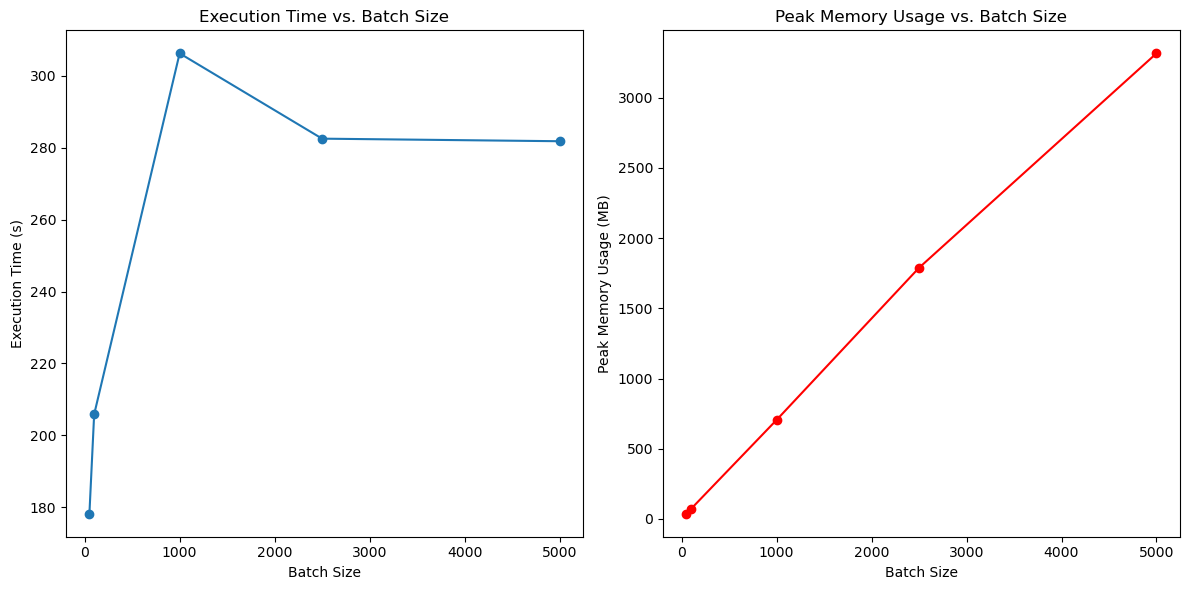

In [9]:
import matplotlib.pyplot as plt

batch_sizes, exec_times, peak_memories = zip(*results)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(batch_sizes, exec_times, marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time vs. Batch Size')

plt.subplot(1, 2, 2)
plt.plot(batch_sizes, peak_memories, marker='o', color='r')
plt.xlabel('Batch Size')
plt.ylabel('Peak Memory Usage (MB)')
plt.title('Peak Memory Usage vs. Batch Size')

plt.tight_layout()
plt.show()


Sparse matrix

In [10]:
soap = SOAP(
    species=species,
    r_cut=4.5,
    n_max=6,
    l_max=5,
    sigma=0.2,
    rbf="gto",
    average="outer",
    periodic=True,
    weighting={
        "function" : "pow",
        "c": 1,
        "m": 5,
        "d": 1,
        "r0": 3.5
    },
    compression={
        "mode": "mu1nu1"
    },
    sparse=True
)

In [11]:
tracemalloc.start()

start_time_soap = time.time()

feats_5k = soap.create(frames_5k, n_jobs=8)

exec_time_soap = time.time() - start_time_soap

print(f"SOAP is finished in {exec_time_soap:.2f} s")

SOAP is finished in 11.28 s


In [14]:
start_time_pca = time.time()

pca = PCA(n_components=2)

csr_feats = feats_5k.tocsr()

reduced_feats = pca.fit_transform(csr_feats)

exec_time_pca = time.time() - start_time_pca
print(f"PCA is finished in {exec_time_pca:.2f} s")

current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6} MB; Peak was {peak / 10**6} MB")
tracemalloc.stop()

PCA is finished in 0.72 s
Current memory usage is 0.0 MB; Peak was 0.0 MB


In [29]:
def ipca_sparse(sparse_feats, batch_size):
    ipca = IncrementalPCA(n_components=2, batch_size=batch_size)

    tracemalloc.start()

    start_time = time.time()

    reduced_feats = ipca.fit_transform(sparse_feats)

    exec_time = time.time() - start_time

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    return exec_time, peak / 10**6

In [30]:
csr_feats = feats_5k.tocsr()

batch_sizes = [50, 100, 500, 1000, 5000]
results = []

for batch_size in batch_sizes:
    exec_time, peak_memory = ipca_sparse(csr_feats, batch_size)
    results.append((batch_size, exec_time, peak_memory))
    print(f"Batch Size: {batch_size}, Execution Time: {exec_time:.2f} s, Peak Memory Usage: {peak_memory:.2f} MB")


Batch Size: 50, Execution Time: 188.99 s, Peak Memory Usage: 78.11 MB
Batch Size: 100, Execution Time: 224.23 s, Peak Memory Usage: 112.91 MB
Batch Size: 500, Execution Time: 415.00 s, Peak Memory Usage: 392.72 MB
Batch Size: 1000, Execution Time: 542.70 s, Peak Memory Usage: 746.10 MB
Batch Size: 5000, Execution Time: 427.40 s, Peak Memory Usage: 2778.27 MB


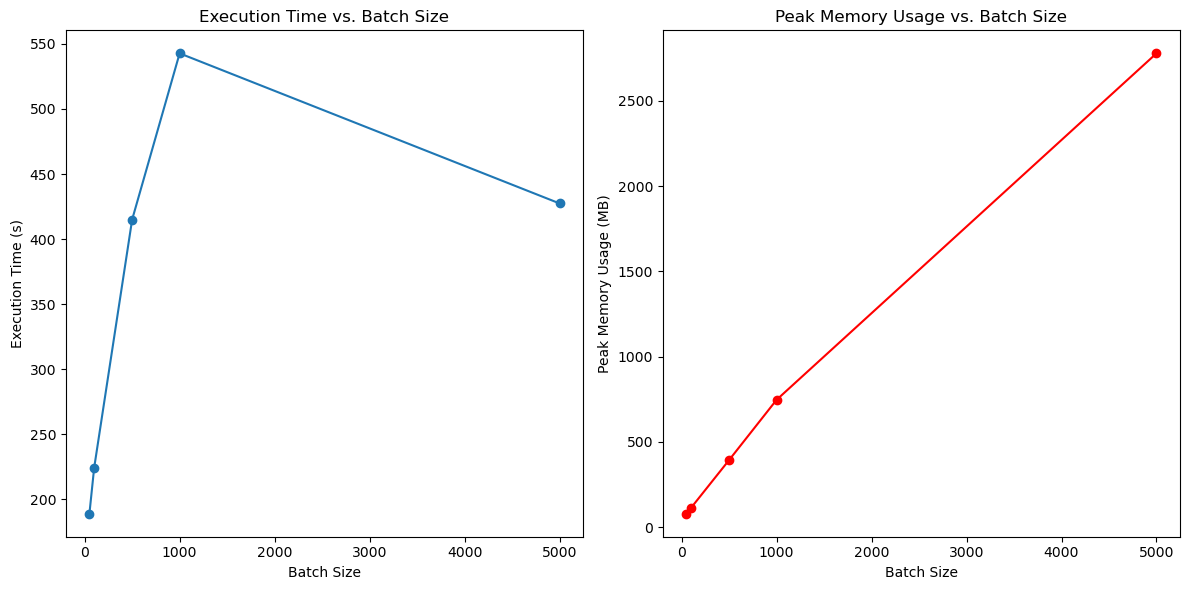

In [31]:
import matplotlib.pyplot as plt

batch_sizes, exec_times, peak_memories = zip(*results)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(batch_sizes, exec_times, marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time vs. Batch Size')

plt.subplot(1, 2, 2)
plt.plot(batch_sizes, peak_memories, marker='o', color='r')
plt.xlabel('Batch Size')
plt.ylabel('Peak Memory Usage (MB)')
plt.title('Peak Memory Usage vs. Batch Size')

plt.tight_layout()
plt.show()
